# VacationPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [67]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os

# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [44]:
# create a new dataframe from the previously created csv file of the city data
city = pd.read_csv("../Output/city_data.csv")
city.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,trofors,65.53,13.41,55.4,76,75,4.70,NO,1595255907
1,1,albany,-35.02,117.89,50.0,81,90,6.93,AU,1595255907
2,2,la ronge,55.10,-105.28,62.6,88,75,3.36,CA,1595255907
3,3,bredasdorp,-34.53,20.04,64.4,72,40,5.82,ZA,1595255907
4,4,punta arenas,-53.15,-70.92,30.2,92,75,2.24,CL,1595255907


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [52]:
# manipulate some of the data from the dataframe so it can be more easily called by gmaps
# humidity is what the heatmap will measure
hum = city["Humidity"].astype(float)
# the maximum value of the heatmap should be the maximum value of humidity in the dataframe (which is basically 100)
maxhum = hum.max()
# use the latitude and longitude to tell gmaps where to place the layer
coords = city[["Lat", "Lng"]]

# making the layout better
figure_layout = {
    "width": "900px",
    "height": "600px",
    "border": "1px solid black",
    "padding": "1px",
    "margin": "0 auto 0 auto"
}

# call gmaps to create a figure, and then add a heatmap layer
fig = gmaps.figure(layout=figure_layout)
heatlayer = gmaps.heatmap_layer(coords, weights=hum, dissipating=False, max_intensity=maxhum, point_radius=4)
fig.add_layer(heatlayer)
fig

#had to be run with classic notebook, an image of the gmap is shown below as a markdown

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

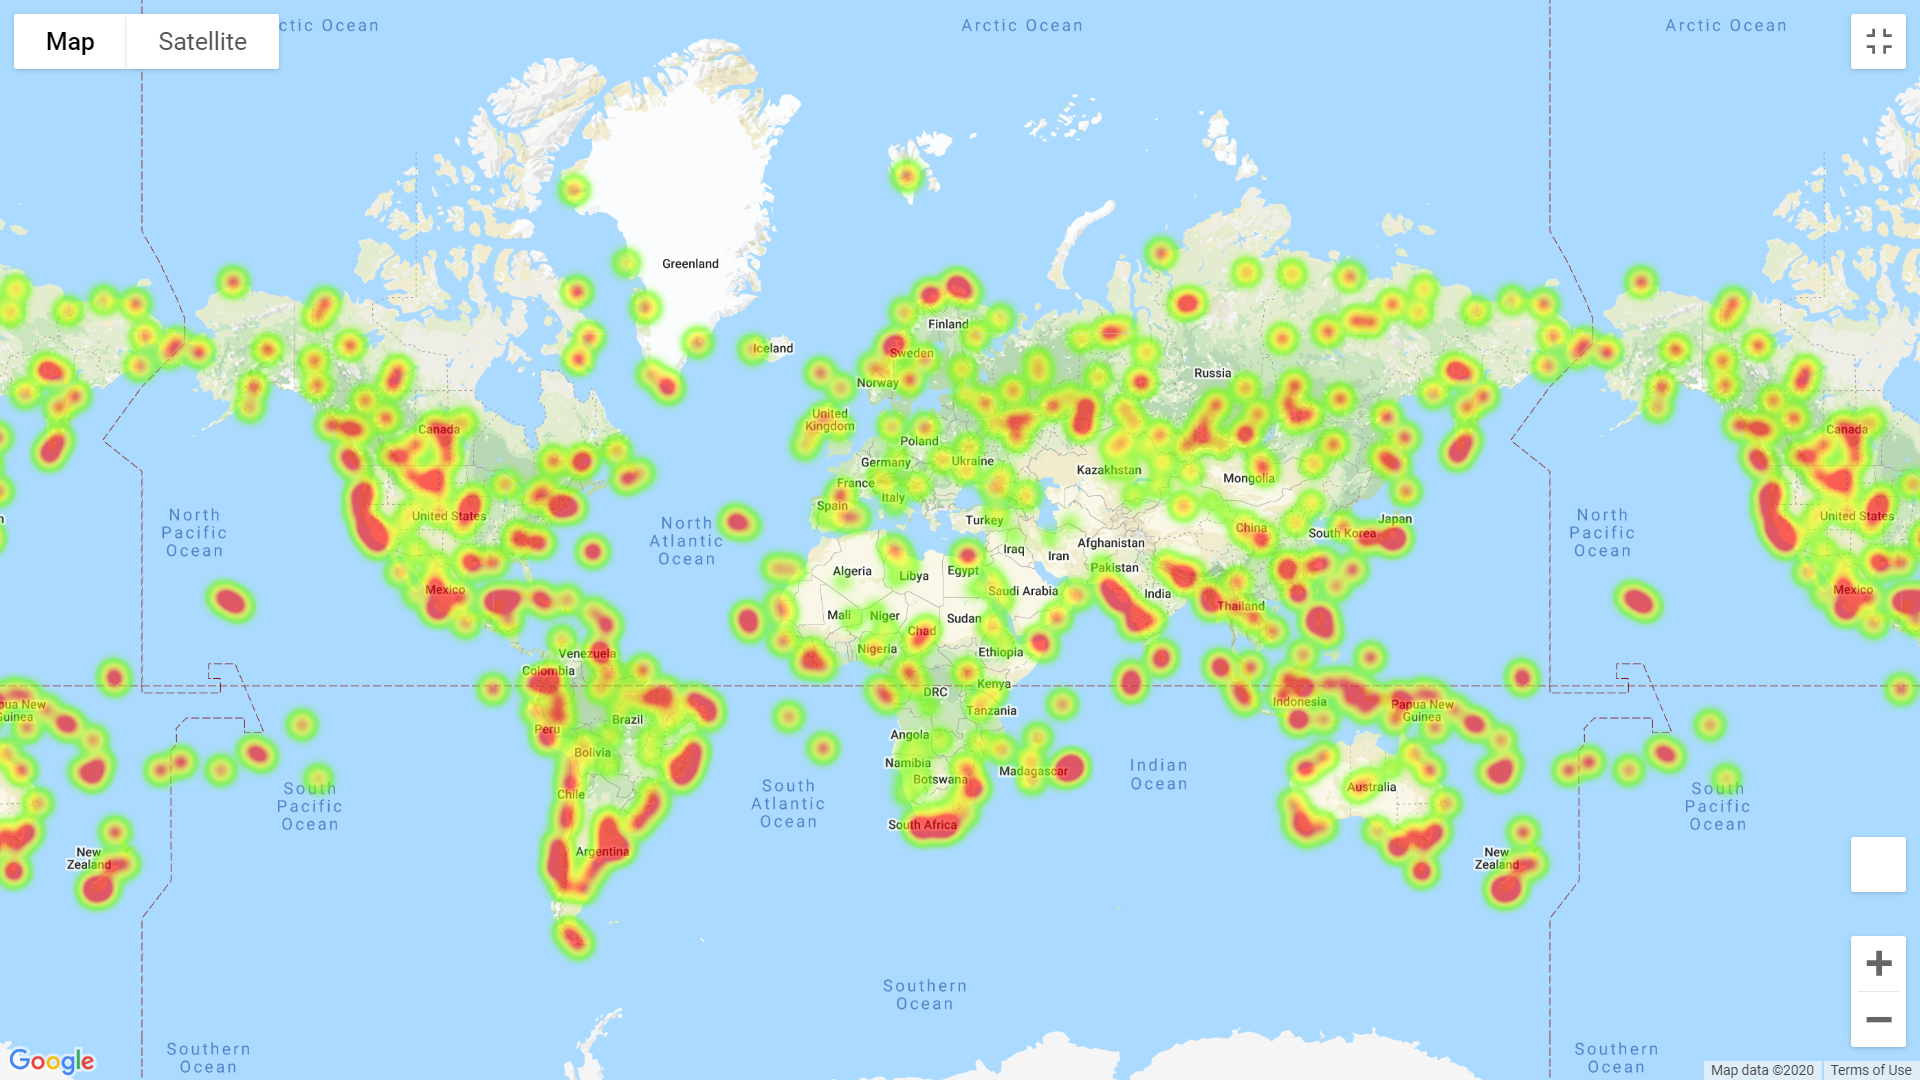

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [46]:
#create a new dataframe that trims the original one down
# use loc to sift out cities that do not fall within 65-75 degrees, have any cloud cover, or have winds over 5mph
newcity = city.loc[(city["Max Temp"] > 65) & (city["Max Temp"] < 75) & (city["Cloudiness"] == 0) & (city["Wind Speed"] < 5)]
#drop any rows with missing data
newcity = newcity.dropna(how="any")
# reset the index
newcity.reset_index(inplace=True)
#drop the index column to clean up the dataframe more
del newcity["index"]
#we should be left with a dataframe of fewer than 10 cities
newcity

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,32,komatipoort,-25.43,31.95,73.40,33,0,3.36,ZA,1595255911
1,42,santa maria del oro,25.93,-105.37,73.76,50,0,2.71,MX,1595255913
2,96,saldanha,-33.01,17.94,73.40,49,0,4.70,ZA,1595255922
3,168,pangkalanbuun,-2.68,111.62,73.08,94,0,2.75,ID,1595255932
4,186,cidreira,-30.18,-50.21,72.91,67,0,3.18,BR,1595255934
5,222,laguna,-28.48,-48.78,74.32,61,0,2.98,BR,1595255940
6,288,guerrero negro,27.98,-114.06,72.84,67,0,3.02,MX,1595255950
7,420,shushenskoye,53.33,91.94,71.60,64,0,3.06,RU,1595255967


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [47]:
#renaming the data frame and creating a list of hotels
hotel_df = newcity
hotels = []

#use a for loop to go through the length of the (now small) dataframe
#and create a set of coordinates for each index corresponding to the latitude or longitude column of the dataframe
for x in range(len(hotel_df)):
    lat = hotel_df.loc[x]["Lat"]
    lon = hotel_df.loc[x]["Lng"]
    
    #set parameters
    params = {
        "location": f"{lat},{lon}",
        "radius": 5000,
        "types": "hotel",
        "key": g_key
    }
    
    #call the google places api to send us data for hotels within 5000 meters of the coordinates we provided
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    response = requests.get(url, params=params).json()
    
    #if there is a hotel named within this range, add it to the list of hotels
    try:
        hotels.append(response["results"][0]["name"])
    #otherwise add nothing
    except:
        hotels.append("")

#create a new column in the dataframe to hold the name of the hotels we found
hotel_df["Hotel Name"] = hotels
# drop any empty rows (cities that did not have hotels within a half km of their coordinates)
# we should now definitely have fewer than 10 hotels
hotel_df = hotel_df.dropna(how="any")
hotel_df

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date,Hotel Name
0,32,komatipoort,-25.43,31.95,73.40,33,0,3.36,ZA,1595255911,Komatipoort
1,42,santa maria del oro,25.93,-105.37,73.76,50,0,2.71,MX,1595255913,Santa María del Oro
2,96,saldanha,-33.01,17.94,73.40,49,0,4.70,ZA,1595255922,Saldanha
3,168,pangkalanbuun,-2.68,111.62,73.08,94,0,2.75,ID,1595255932,Pangkalan Bun
4,186,cidreira,-30.18,-50.21,72.91,67,0,3.18,BR,1595255934,CIDREIRA
5,222,laguna,-28.48,-48.78,74.32,61,0,2.98,BR,1595255940,Laguna
6,288,guerrero negro,27.98,-114.06,72.84,67,0,3.02,MX,1595255950,Guerrero Negro
7,420,shushenskoye,53.33,91.94,71.60,64,0,3.06,RU,1595255967,Shushenskoe


In [48]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{City}</dd>
<dt>Country</dt><dd>{Country}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["Lat", "Lng"]]

In [66]:
# Add marker layer ontop of heat map
marker = gmaps.marker_layer(locations, info_box_content = hotel_info)
fig.add_layer(marker)
fig

#again run with classic notebook, an image of the gmap is provided below in markdown
#demonstrating the markers were successfully added, and when clicked, they do provide 
#the name of the hotel, as well as the city and country code it's in

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

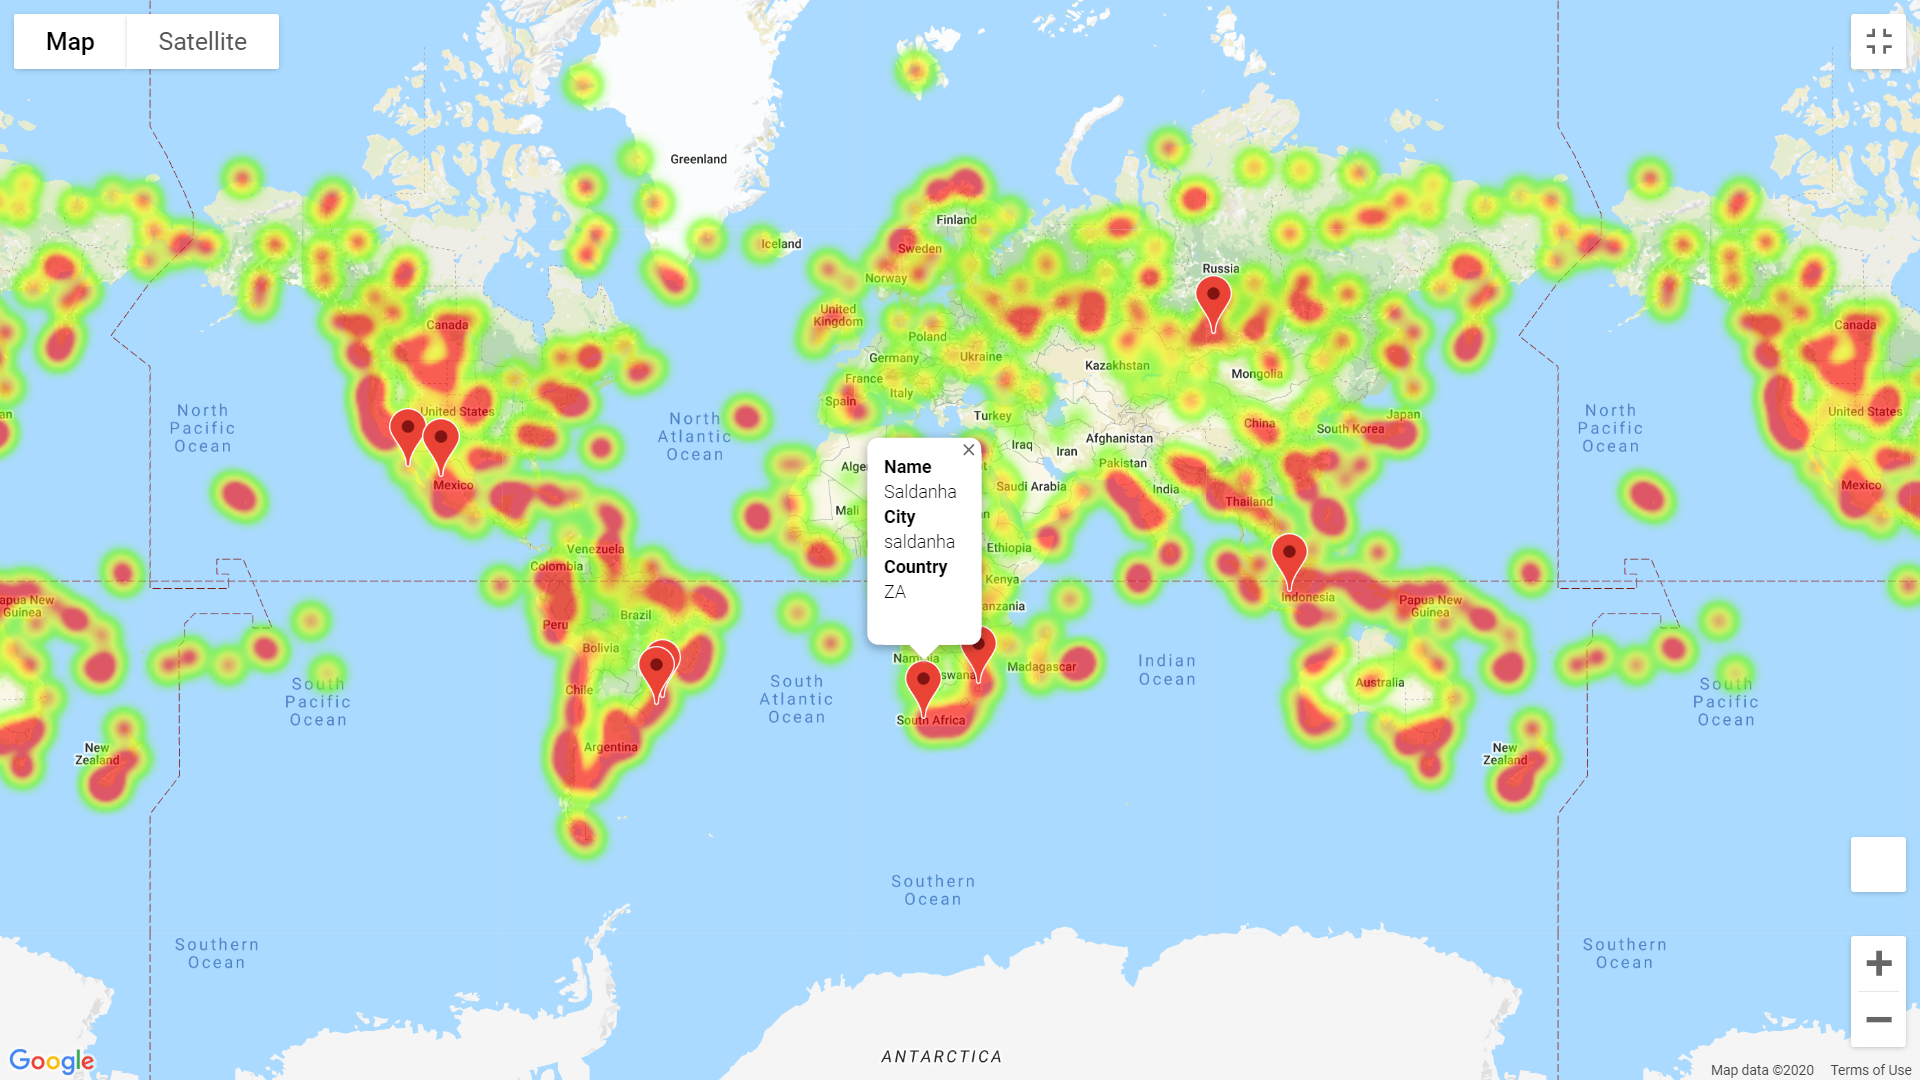